In [200]:
import pathlib

# Define data directory
train_dir = pathlib.Path('data/train')
test_dir = pathlib.Path('data/test')
train_masks_dir = pathlib.Path('masks/train')
test_masks_dir = pathlib.Path('masks/test')

In [201]:
import os
import cv2
import numpy as np

# check if the pixels are normalized
img = cv2.imread(os.path.join(test_dir, 'P1MF1_C.png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img), np.min(img))
img_mask = cv2.imread(os.path.join(test_masks_dir, 'P1MF1_C.Png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img_mask), np.min(img_mask))
print(img.shape, img_mask.shape)

255 0
255 0
(4096, 4096) (4096, 4096)


In [202]:
X_train = []
y_train = []
X_test = []
y_test = []

for img_path in train_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_train.append(img)
    mask_path = os.path.join(train_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_train.append(img_mask)

for img_path in test_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_test.append(img)
    mask_path = os.path.join(test_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_test.append(img_mask)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# # Expand the dimensions of the images
#X_train = np.expand_dims(X_train, axis = 3)
y_train = np.expand_dims(y_train, axis = 3)
#X_test = np.expand_dims(X_test, axis = 3)
y_test = np.expand_dims(y_test, axis = 3)

print(X_train.shape, y_train.shape)

(50, 256, 256, 3) (50, 256, 256, 1)


In [203]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [204]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.round(tf.cast(input_mask, tf.float32) / 255.0)
    return input_image, input_mask

def load_image(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask = tf.image.resize(input_mask,(128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [205]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [206]:
train_ds = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print("the shape of the train dataset is: ", train_ds)
# Show the labels of the first image
for image, mask in train_ds.take(1):
    print("the shape of the image is: ", image.numpy().shape)
    print("the shape of the mask is: ", mask.numpy().shape)
    print("the label of the first image is: ", mask.numpy())

the shape of the train dataset is:  <_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
the shape of the image is:  (128, 128, 3)
the shape of the mask is:  (128, 128, 1)
the label of the first image is:  [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [207]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [208]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_ds.batch(BATCH_SIZE)

In [209]:
from matplotlib import pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

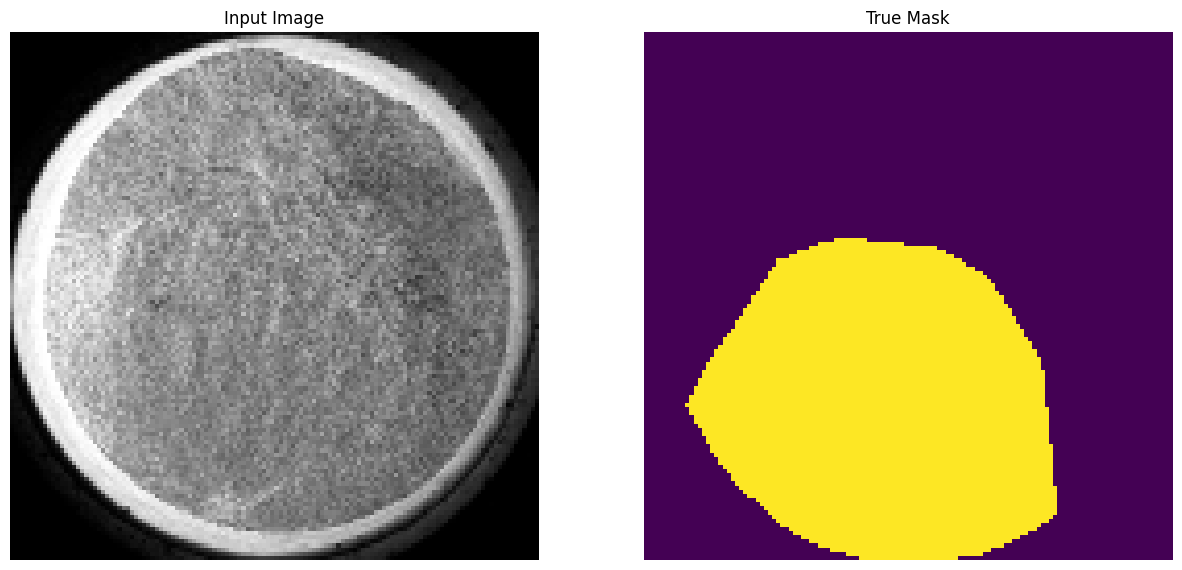

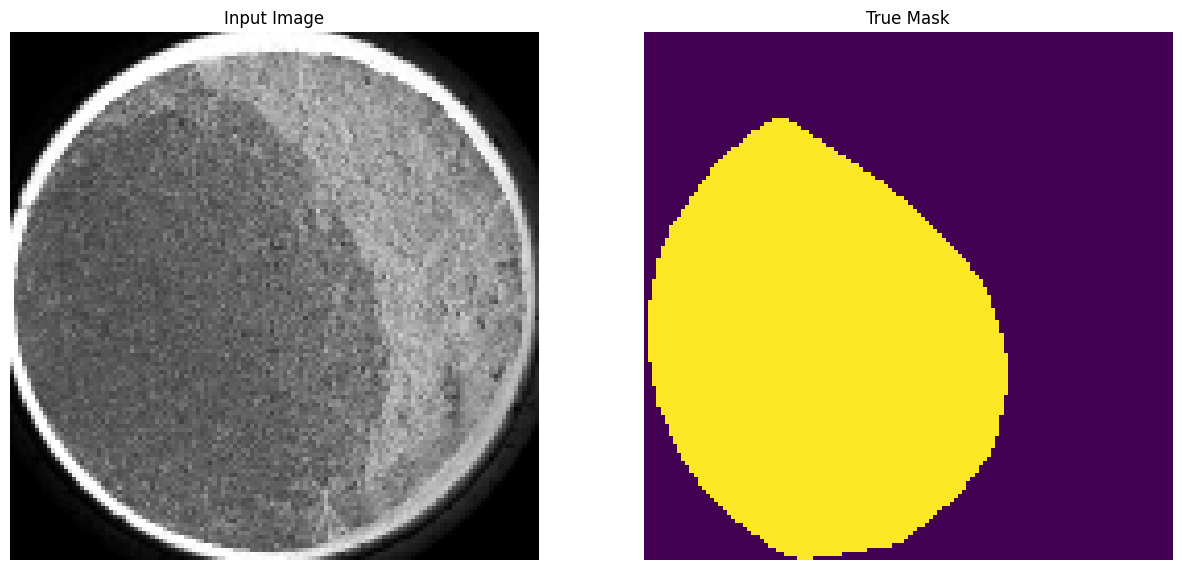

In [210]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [211]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [212]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [213]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [214]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [215]:
# Try the model
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [216]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


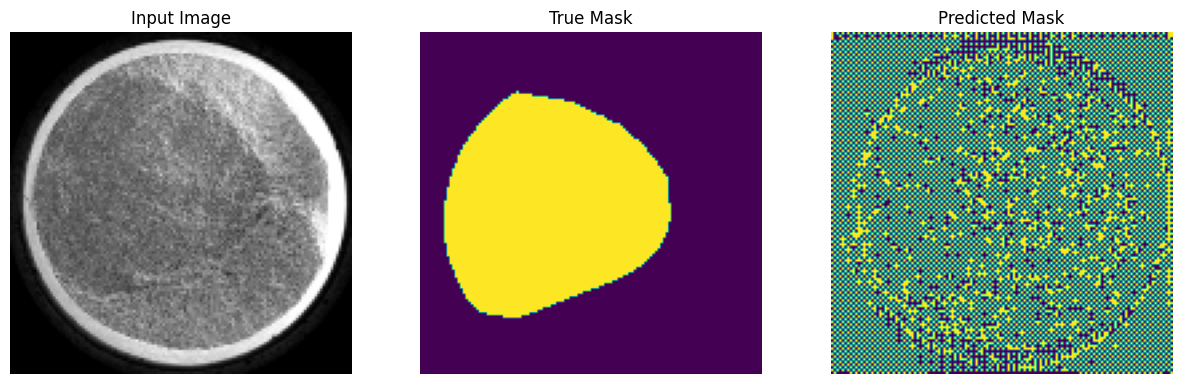

1/1 [==============================] - 0s 216ms/step


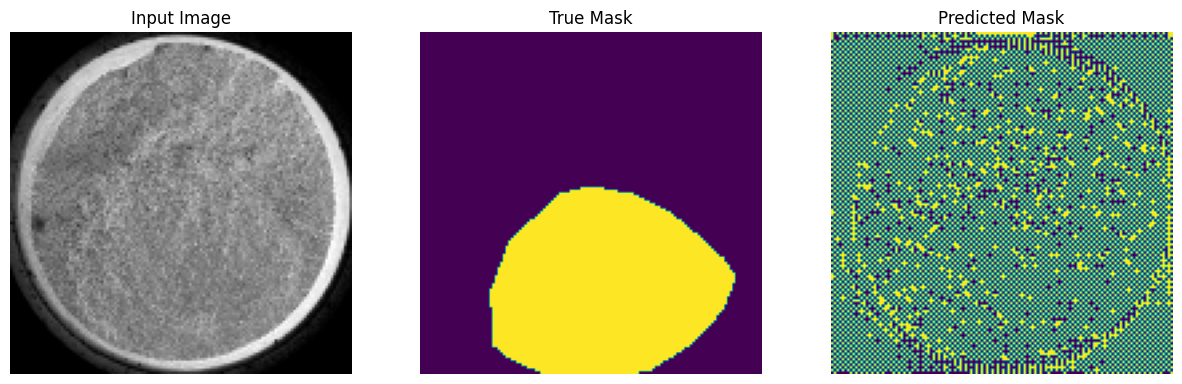

1/1 [==============================] - 0s 238ms/step


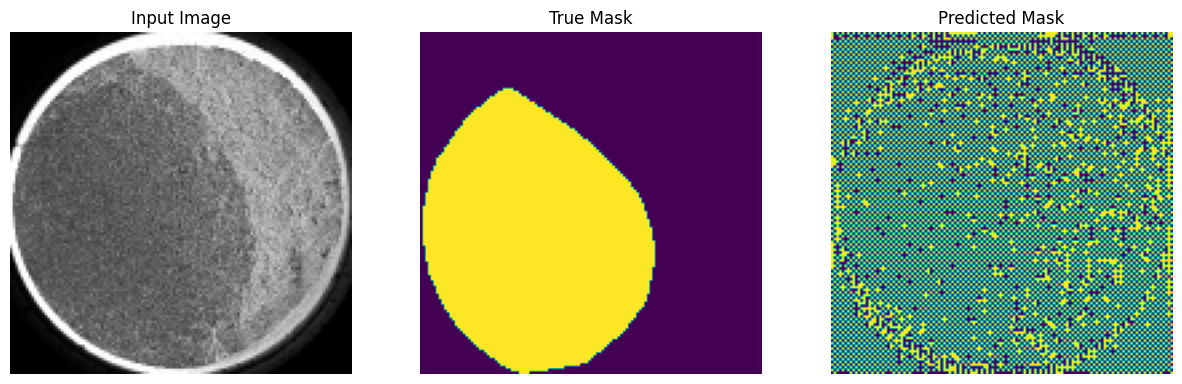

In [217]:
show_predictions(train_batches, 3)

In [218]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(train_batches, 1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
1/1 [==============================] - 0s 263ms/step


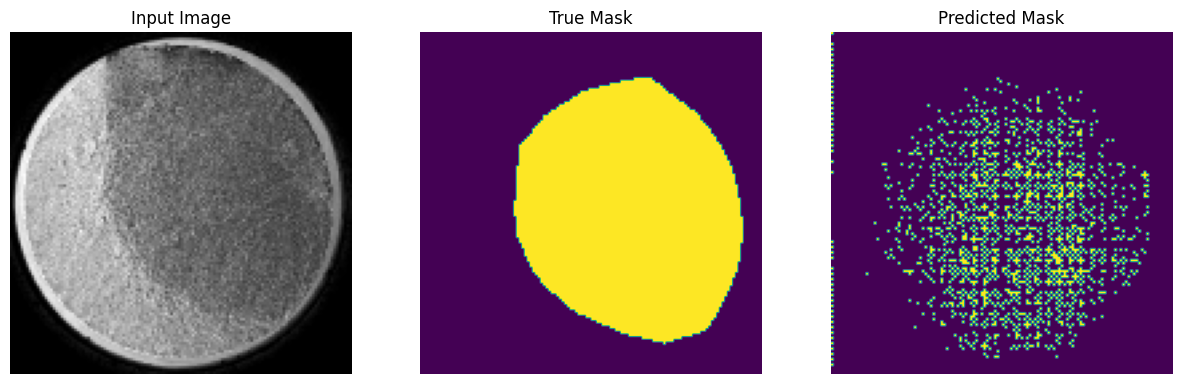


Sample Prediction after epoch 1

6/6 [==============================] - 9s 900ms/step - loss: 0.7055 - accuracy: 0.6102 - val_loss: 0.6596 - val_accuracy: 0.6387
Epoch 2/20
1/1 [==============================] - 0s 286ms/step


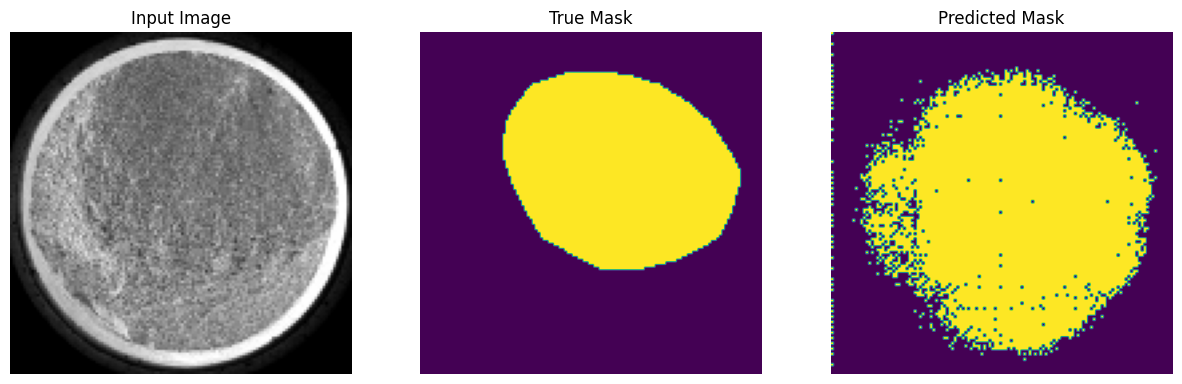


Sample Prediction after epoch 2

6/6 [==============================] - 4s 731ms/step - loss: 0.5424 - accuracy: 0.7185 - val_loss: 0.5471 - val_accuracy: 0.7606
Epoch 3/20
1/1 [==============================] - 0s 239ms/step


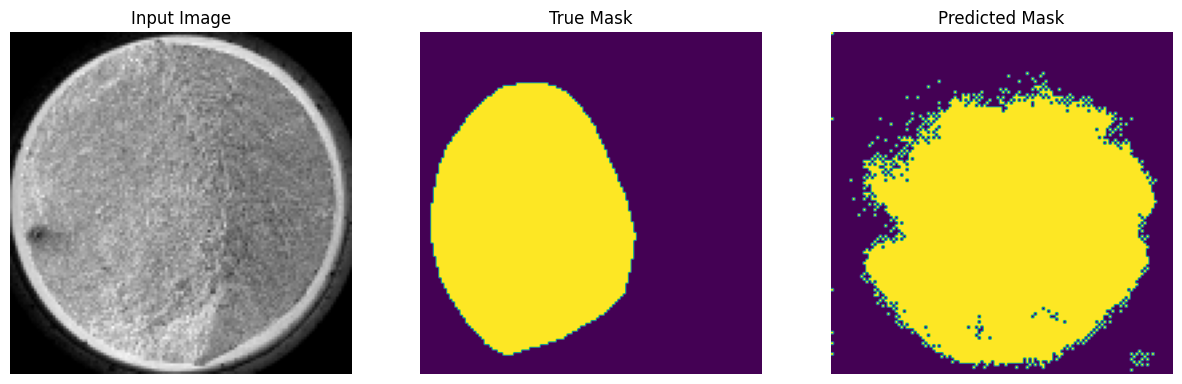


Sample Prediction after epoch 3

6/6 [==============================] - 4s 656ms/step - loss: 0.4654 - accuracy: 0.7802 - val_loss: 0.6192 - val_accuracy: 0.7612
Epoch 4/20
1/1 [==============================] - 0s 247ms/step


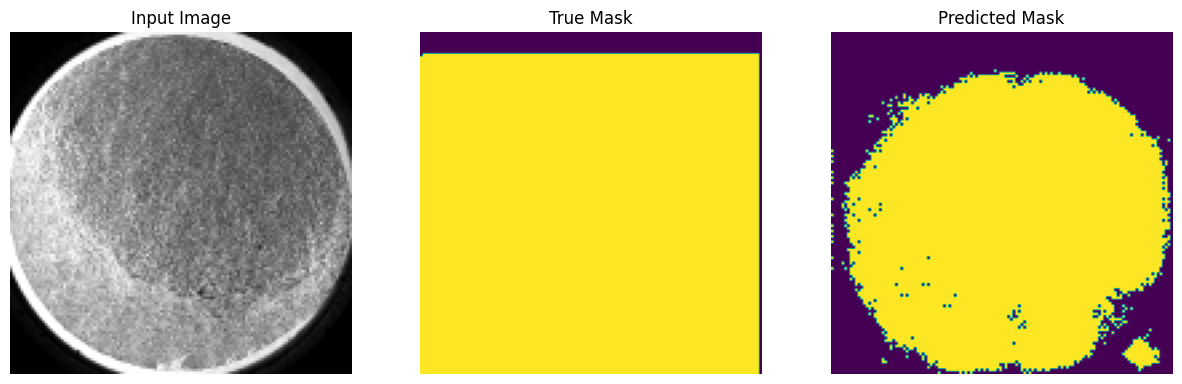


Sample Prediction after epoch 4

6/6 [==============================] - 4s 635ms/step - loss: 0.4511 - accuracy: 0.7963 - val_loss: 0.7786 - val_accuracy: 0.7224
Epoch 5/20
1/1 [==============================] - 0s 241ms/step


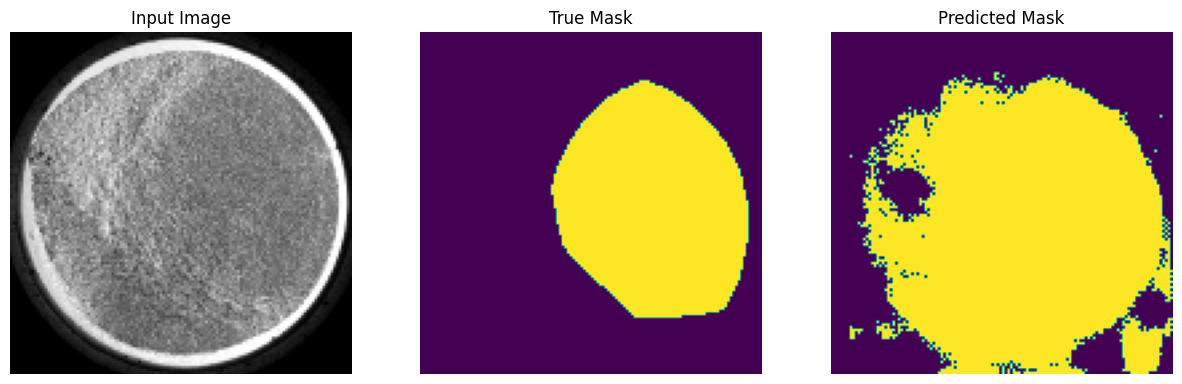


Sample Prediction after epoch 5

6/6 [==============================] - 3s 615ms/step - loss: 0.4006 - accuracy: 0.8233 - val_loss: 0.7571 - val_accuracy: 0.7544
Epoch 6/20
1/1 [==============================] - 0s 239ms/step


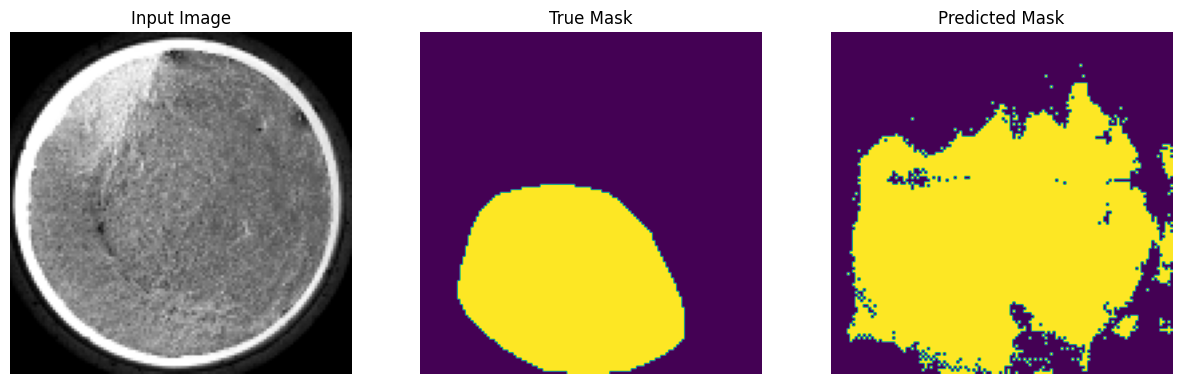


Sample Prediction after epoch 6

6/6 [==============================] - 3s 605ms/step - loss: 0.3427 - accuracy: 0.8515 - val_loss: 0.7146 - val_accuracy: 0.7487
Epoch 7/20
1/1 [==============================] - 0s 230ms/step


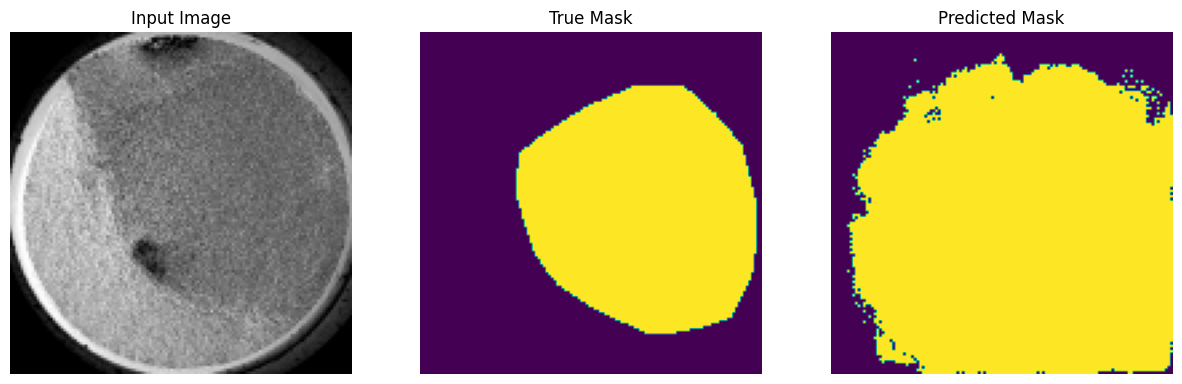


Sample Prediction after epoch 7

6/6 [==============================] - 3s 596ms/step - loss: 0.3660 - accuracy: 0.8429 - val_loss: 1.3869 - val_accuracy: 0.6214
Epoch 8/20
1/1 [==============================] - 0s 254ms/step


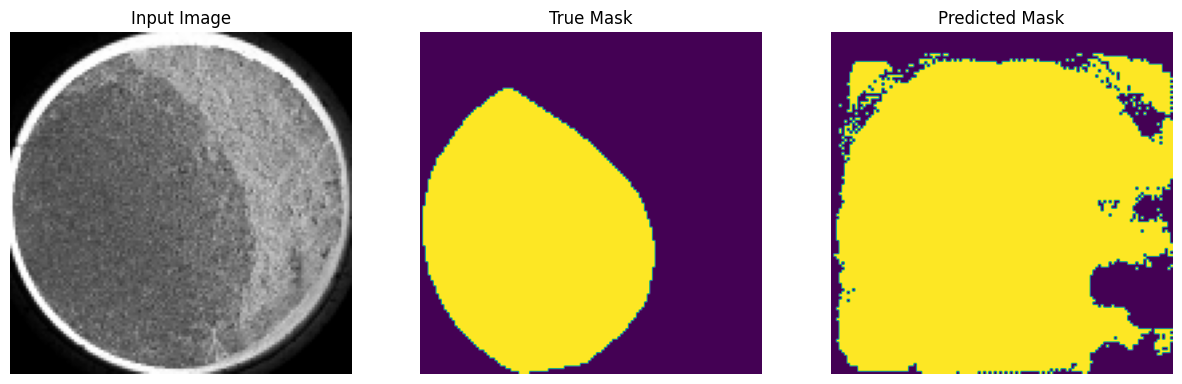


Sample Prediction after epoch 8

6/6 [==============================] - 4s 646ms/step - loss: 0.3227 - accuracy: 0.8627 - val_loss: 1.0443 - val_accuracy: 0.6480
Epoch 9/20
1/1 [==============================] - 0s 245ms/step


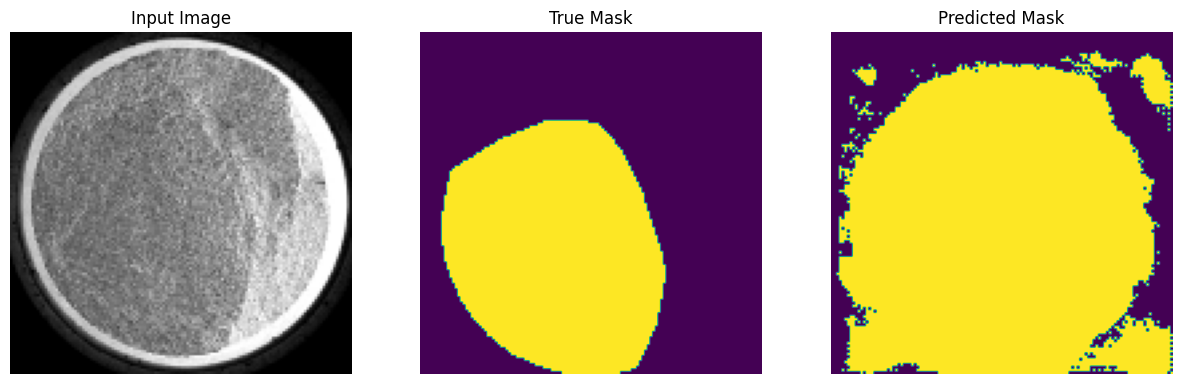


Sample Prediction after epoch 9

6/6 [==============================] - 3s 645ms/step - loss: 0.3177 - accuracy: 0.8652 - val_loss: 1.4695 - val_accuracy: 0.6037
Epoch 10/20
1/1 [==============================] - 0s 224ms/step


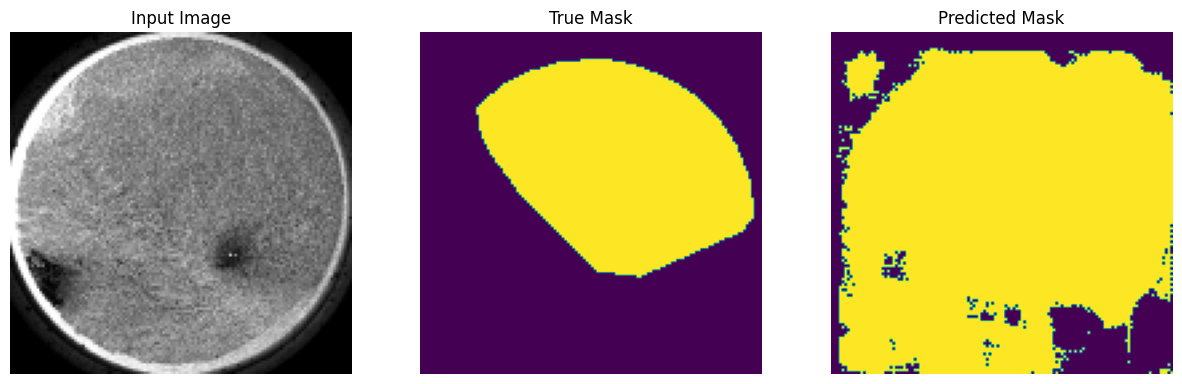


Sample Prediction after epoch 10

6/6 [==============================] - 3s 579ms/step - loss: 0.2967 - accuracy: 0.8739 - val_loss: 0.9971 - val_accuracy: 0.6845
Epoch 11/20
1/1 [==============================] - 0s 250ms/step


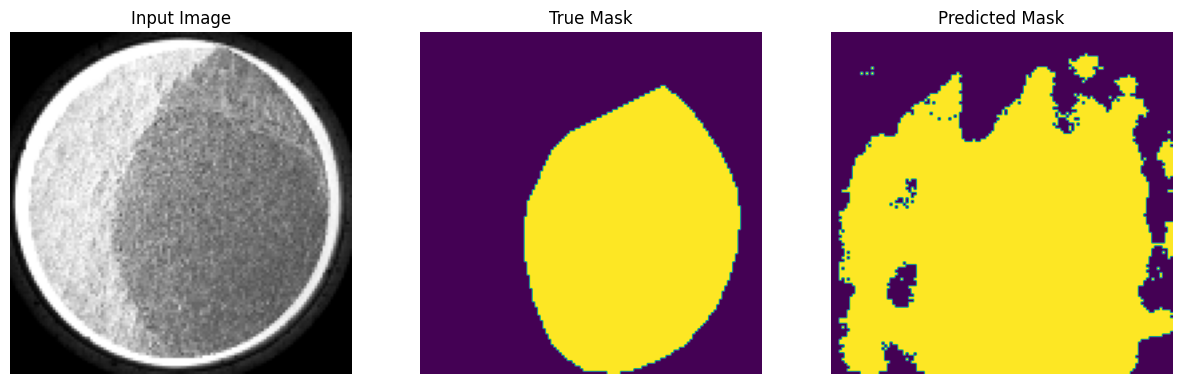


Sample Prediction after epoch 11

6/6 [==============================] - 4s 633ms/step - loss: 0.3109 - accuracy: 0.8681 - val_loss: 1.3338 - val_accuracy: 0.6285
Epoch 12/20
1/1 [==============================] - 0s 265ms/step


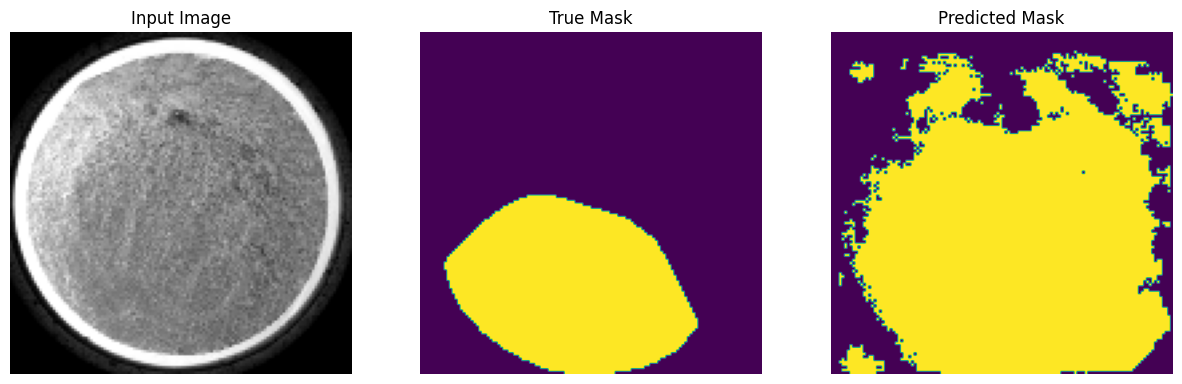


Sample Prediction after epoch 12

6/6 [==============================] - 4s 652ms/step - loss: 0.3210 - accuracy: 0.8554 - val_loss: 1.3042 - val_accuracy: 0.6259
Epoch 13/20
1/1 [==============================] - 0s 229ms/step


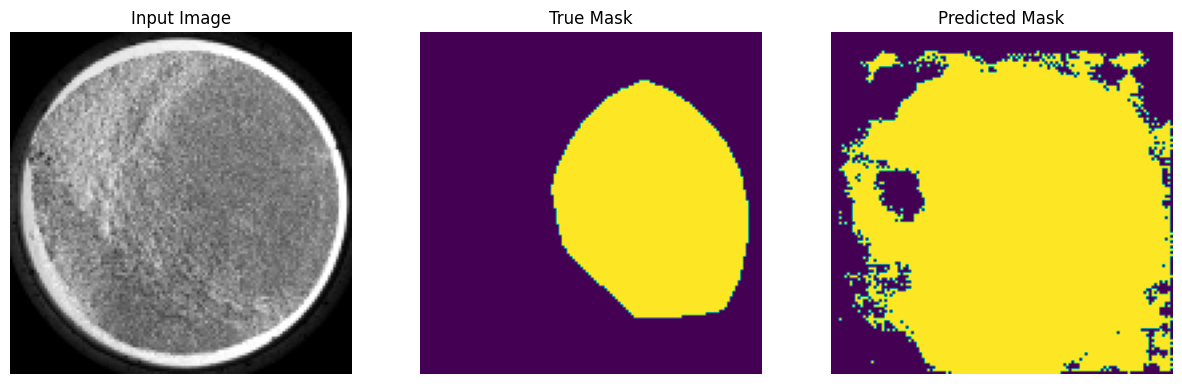


Sample Prediction after epoch 13

6/6 [==============================] - 3s 600ms/step - loss: 0.2683 - accuracy: 0.8850 - val_loss: 0.9467 - val_accuracy: 0.6543
Epoch 14/20
1/1 [==============================] - 0s 227ms/step


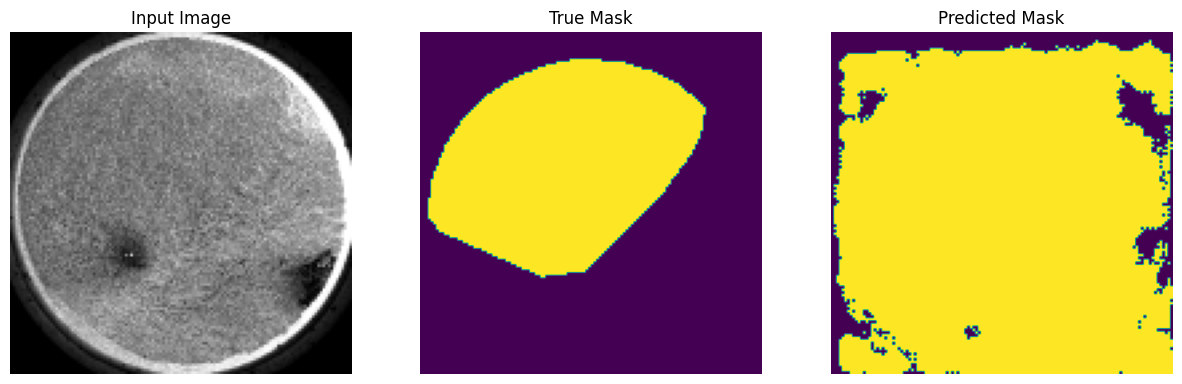


Sample Prediction after epoch 14

6/6 [==============================] - 3s 583ms/step - loss: 0.2609 - accuracy: 0.8862 - val_loss: 1.0685 - val_accuracy: 0.6515
Epoch 15/20
1/1 [==============================] - 0s 238ms/step


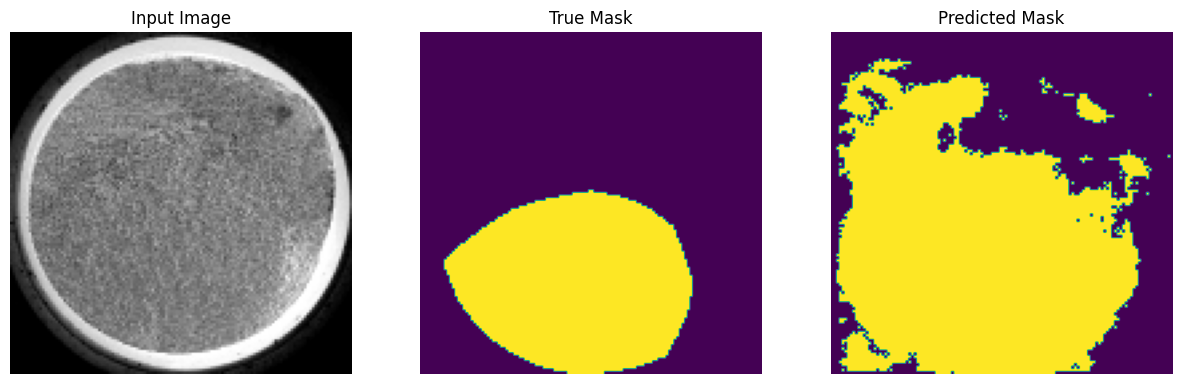


Sample Prediction after epoch 15

6/6 [==============================] - 4s 647ms/step - loss: 0.2444 - accuracy: 0.8956 - val_loss: 1.1773 - val_accuracy: 0.6154
Epoch 16/20
1/1 [==============================] - 0s 271ms/step


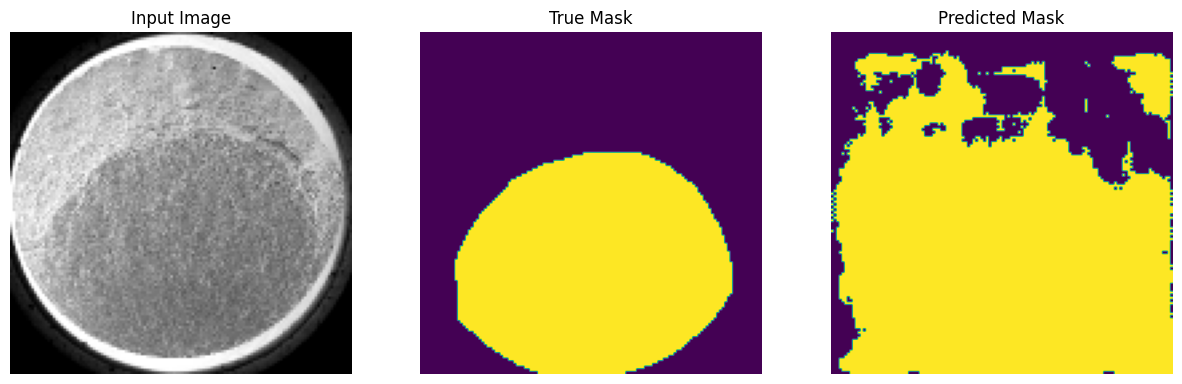


Sample Prediction after epoch 16

6/6 [==============================] - 4s 680ms/step - loss: 0.2142 - accuracy: 0.9111 - val_loss: 1.1096 - val_accuracy: 0.6734
Epoch 17/20
1/1 [==============================] - 0s 254ms/step


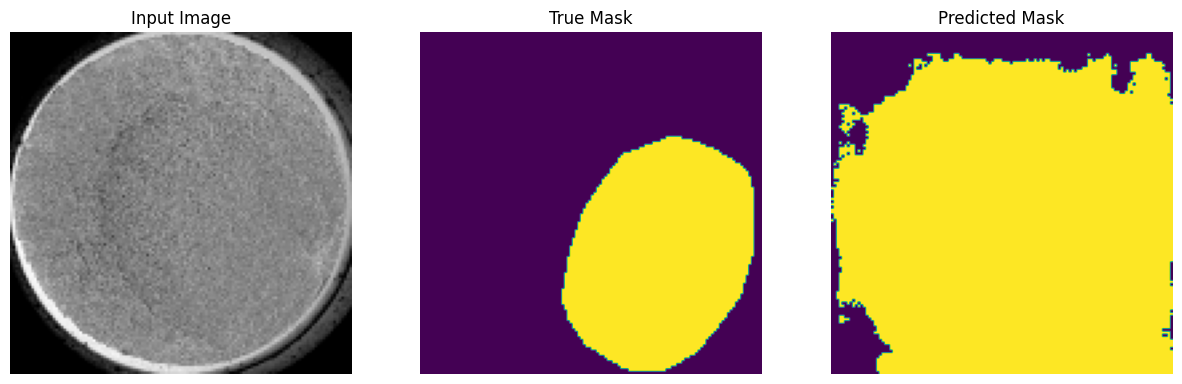


Sample Prediction after epoch 17

6/6 [==============================] - 3s 610ms/step - loss: 0.2906 - accuracy: 0.8714 - val_loss: 1.8103 - val_accuracy: 0.6382
Epoch 18/20
1/1 [==============================] - 0s 217ms/step


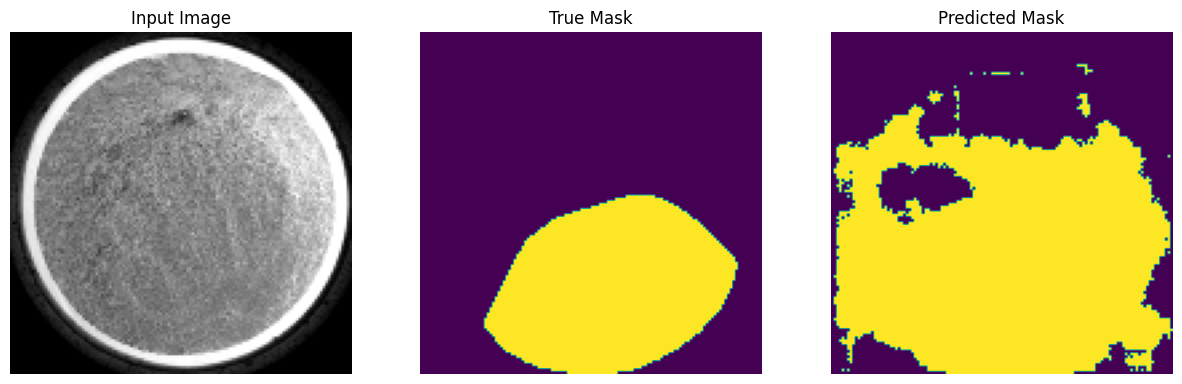


Sample Prediction after epoch 18

6/6 [==============================] - 3s 603ms/step - loss: 0.2852 - accuracy: 0.8735 - val_loss: 1.0377 - val_accuracy: 0.6770
Epoch 19/20
1/1 [==============================] - 0s 490ms/step


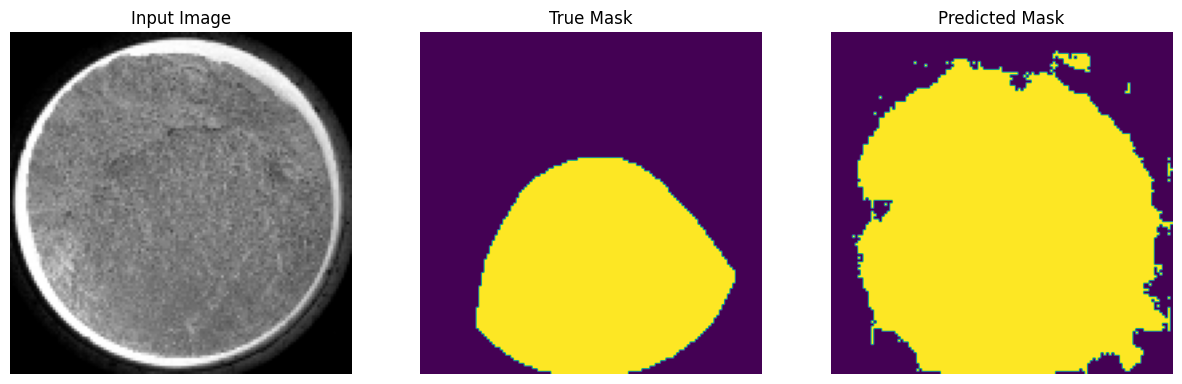


Sample Prediction after epoch 19

6/6 [==============================] - 5s 920ms/step - loss: 0.2167 - accuracy: 0.9100 - val_loss: 1.1813 - val_accuracy: 0.7011
Epoch 20/20
1/1 [==============================] - 0s 263ms/step


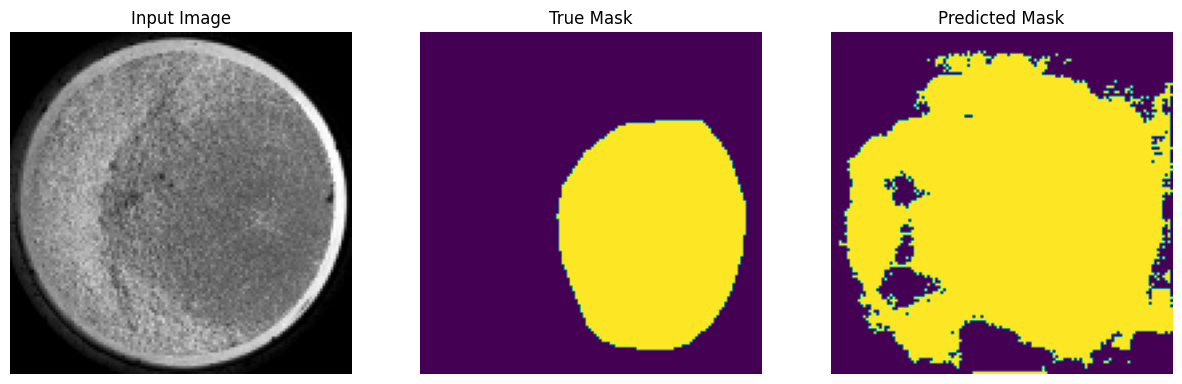


Sample Prediction after epoch 20

6/6 [==============================] - 5s 810ms/step - loss: 0.2283 - accuracy: 0.9003 - val_loss: 0.9917 - val_accuracy: 0.7093


In [219]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test)//BATCH_SIZE
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [220]:
# evaluate the model
model.evaluate(test_batches, verbose=1)

2/2 [==============================] - 0s 148ms/step - loss: 1.1076 - accuracy: 0.6802


[1.1075526475906372, 0.6801851987838745]

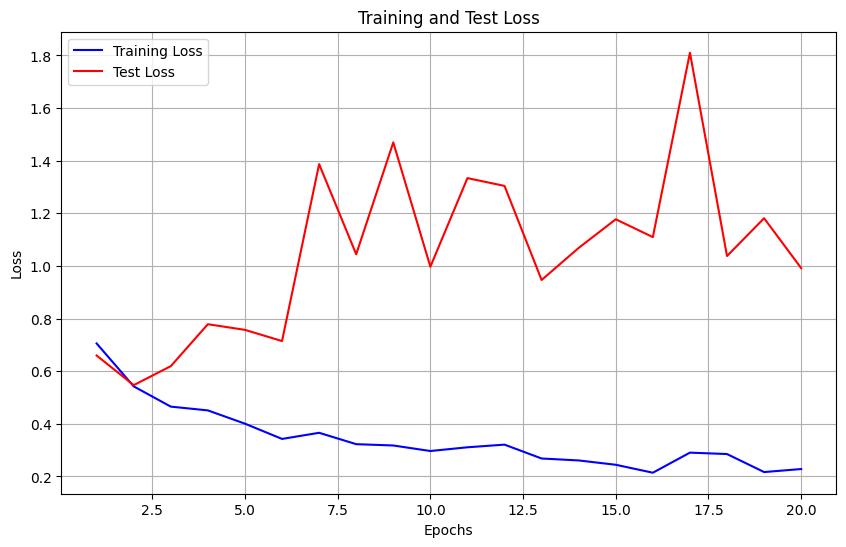

In [221]:
import matplotlib.pyplot as plt

# Extract data from the model history
train_loss = model_history.history['loss']
test_loss = model_history.history['val_loss']

# Create an array of the epoch numbers for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

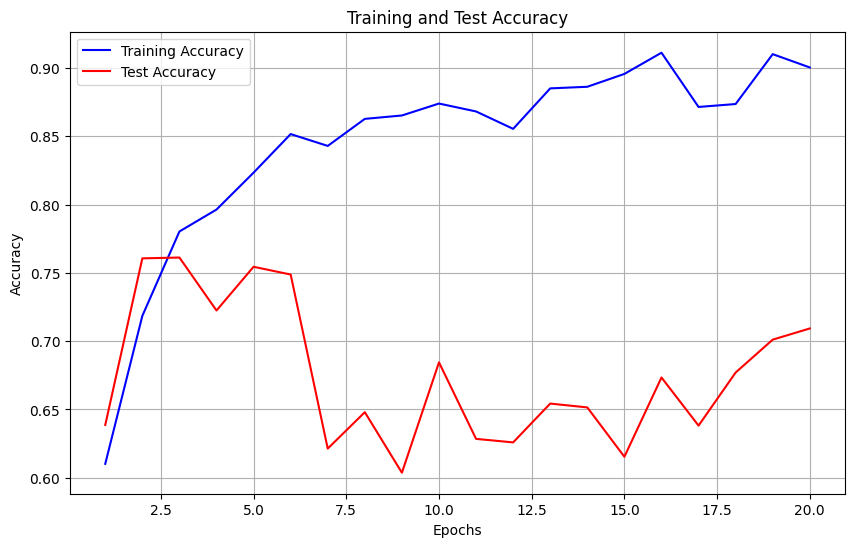

In [222]:
# Plot the training and testing accuracy
train_acc = model_history.history['accuracy']
test_acc = model_history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, test_acc, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()